In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split,  cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

In [2]:
df = pd.read_csv("insurance.csv")

In [14]:
print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())
print("Basic info:")
df.info()
print("Number of missing values:", df.isna().sum().sum())

Dataset shape: (1338, 7)
First few rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Number of missing values: 0


In [5]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


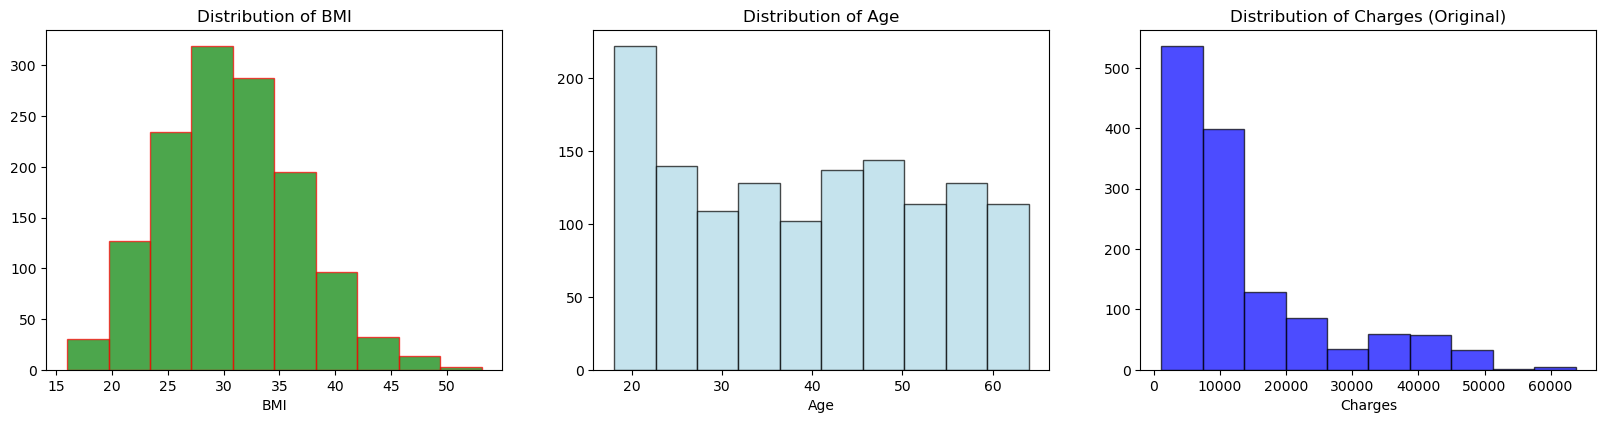

In [16]:
# --- Exploratory Data Analysis (EDA) ---
plt.figure(figsize=(20, 15))

# BMI Distribution
plt.subplot(3, 3, 1)
plt.hist(df['bmi'], color='green', edgecolor='red', alpha=0.7)
plt.xlabel('BMI')
plt.title('Distribution of BMI')

# Age Distribution
plt.subplot(3, 3, 2)
plt.hist(df['age'], color='lightblue', edgecolor='black', alpha=0.7)
plt.xlabel('Age')
plt.title('Distribution of Age')

# Charges Distribution
plt.subplot(3, 3, 3)
plt.hist(df['charges'], color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Charges')
plt.title('Distribution of Charges (Original)')
plt.show()

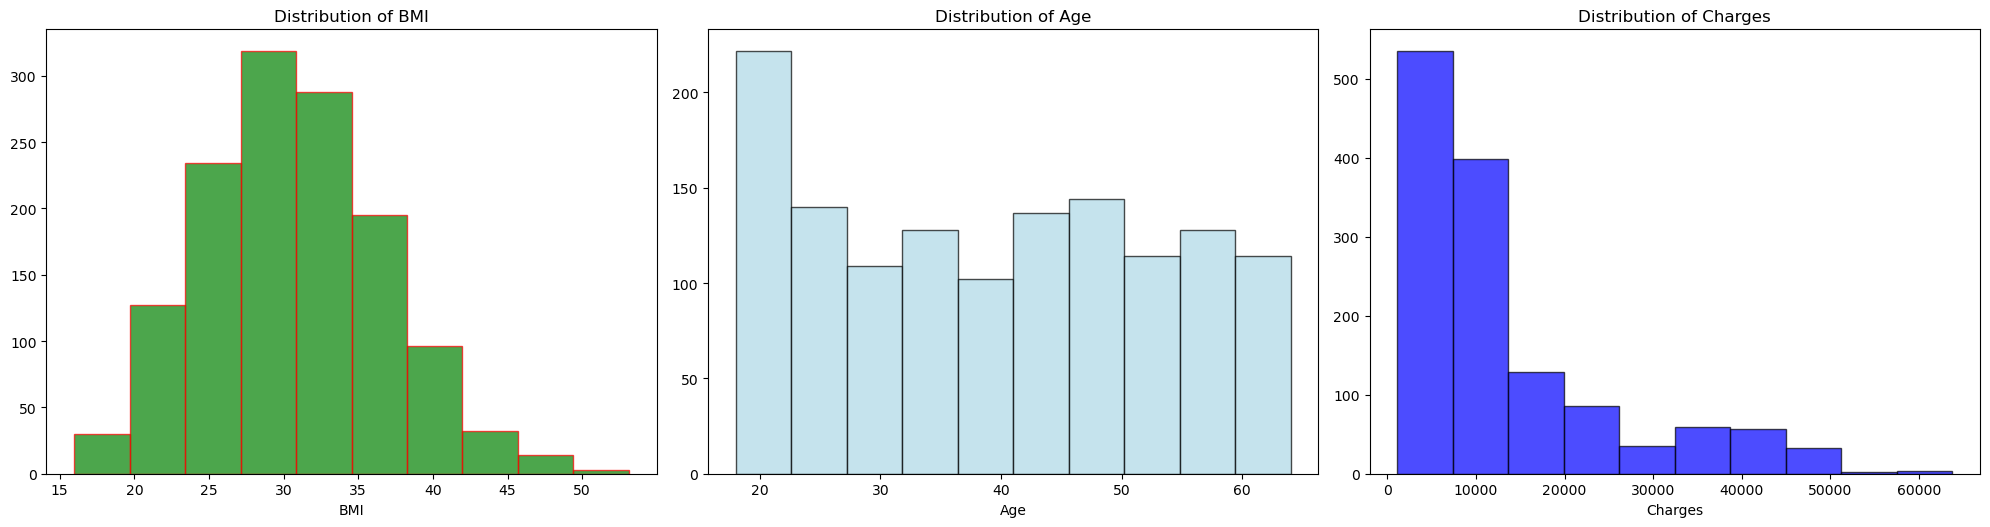

In [18]:
import matplotlib.pyplot as plt

# Define columns and plotting parameters in a list of tuples:
# (column_name, title_label, color, edgecolor)
plot_specs = [
    ("bmi",     "BMI",      "green",     "red"),
    ("age",     "Age",      "lightblue", "black"),
    ("charges", "Charges",  "blue",      "black")
]

plt.figure(figsize=(20, 15))

for i, (col, label, color, edgecol) in enumerate(plot_specs, start=1):
    plt.subplot(3, 3, i)
    plt.hist(df[col], color=color, edgecolor=edgecol, alpha=0.7)
    plt.xlabel(label)
    # You can customize the title, e.g. "Distribution of <label>"
    plt.title(f"Distribution of {label}")

plt.tight_layout()
plt.show()


In [20]:
# Skewness
print("Skewness of variables:")
skewness = pd.DataFrame({
    'Skewness': [stats.skew(df['bmi']), stats.skew(df['age']), stats.skew(df['charges'])]
}, index=['bmi', 'age', 'charges'])
print(skewness)

Skewness of variables:
         Skewness
bmi      0.283729
age      0.055610
charges  1.514180


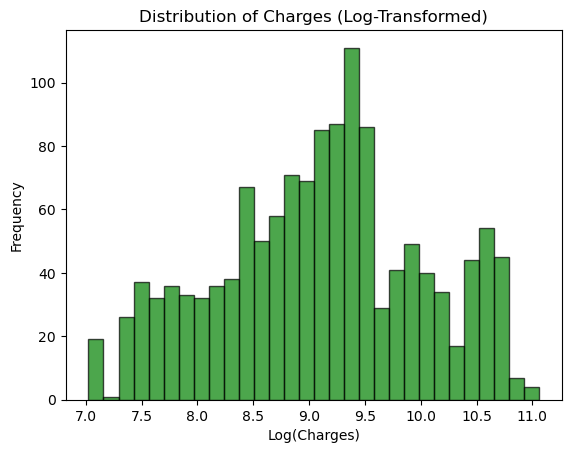

In [22]:
# Log transformation for charges
df['charges_log'] = np.log1p(df['charges'])
plt.hist(df['charges_log'], bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title("Distribution of Charges (Log-Transformed)")
plt.xlabel("Log(Charges)")
plt.ylabel("Frequency")
plt.show()

Skewness (original 'charges'): 1.5159
Skewness (log-transformed 'charges_log'): -0.0898


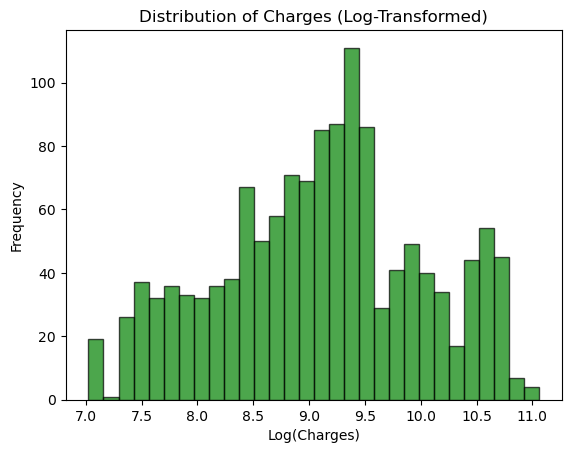

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Log transform
df['charges_log'] = np.log1p(df['charges'])

# Calculate skewness of original and log-transformed data
original_skewness = df['charges'].skew()
log_skewness = df['charges_log'].skew()

print(f"Skewness (original 'charges'): {original_skewness:.4f}")
print(f"Skewness (log-transformed 'charges_log'): {log_skewness:.4f}")

# Plot histogram of the log-transformed charges
plt.hist(df['charges_log'], bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title("Distribution of Charges (Log-Transformed)")
plt.xlabel("Log(Charges)")
plt.ylabel("Frequency")
plt.show()


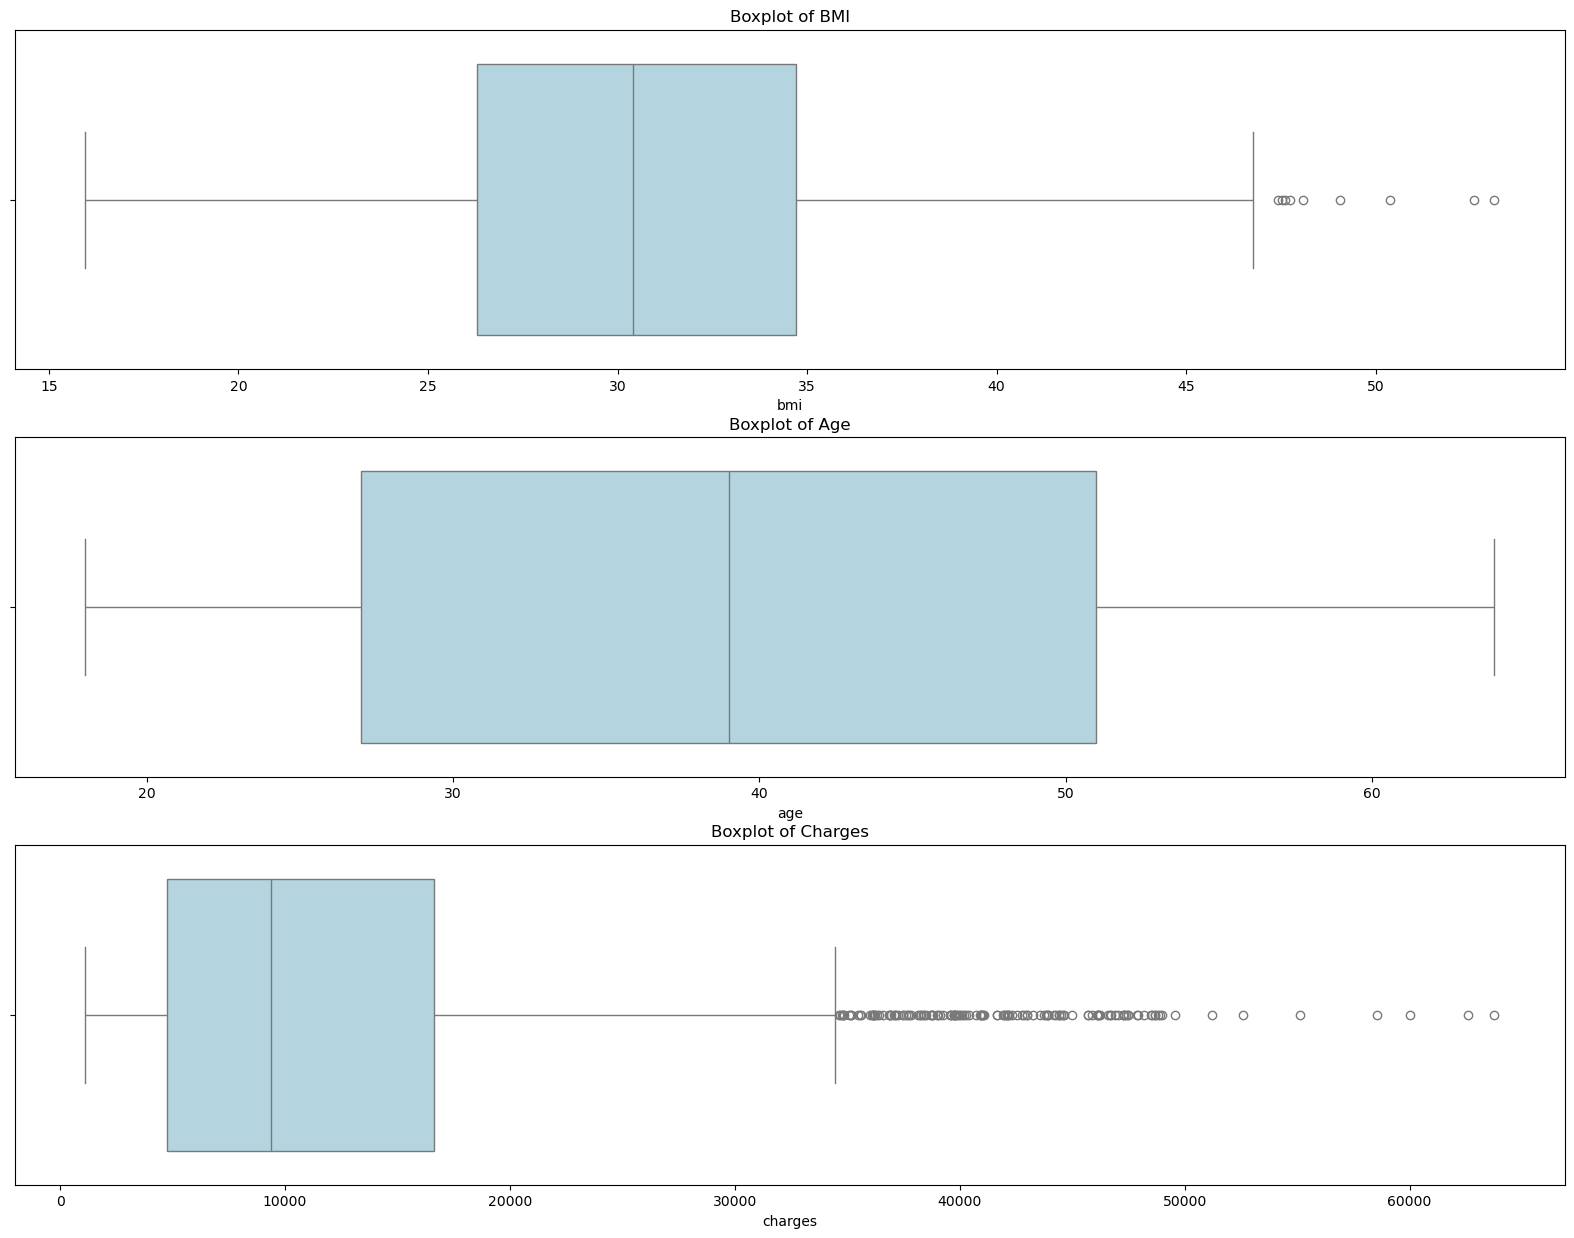

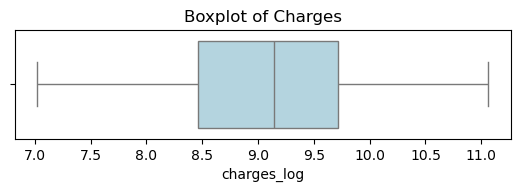

In [11]:
# --- Boxplots for Outlier Detection ---
df['charges_log'] = np.log1p(df['charges'])
plt.figure(figsize=(20, 15))

plt.subplot(3, 1, 1)
sns.boxplot(x=df['bmi'], color='lightblue')
plt.title('Boxplot of BMI')

plt.subplot(3, 1, 2)
sns.boxplot(x=df['age'], color='lightblue')
plt.title('Boxplot of Age')

plt.subplot(3, 1, 3)
sns.boxplot(x=df['charges'], color='lightblue')
plt.title('Boxplot of Charges')
plt.show()

plt.subplot(3, 1, 3)
sns.boxplot(x=df['charges_log'], color='lightblue')
plt.title('Boxplot of Charges')
plt.show()

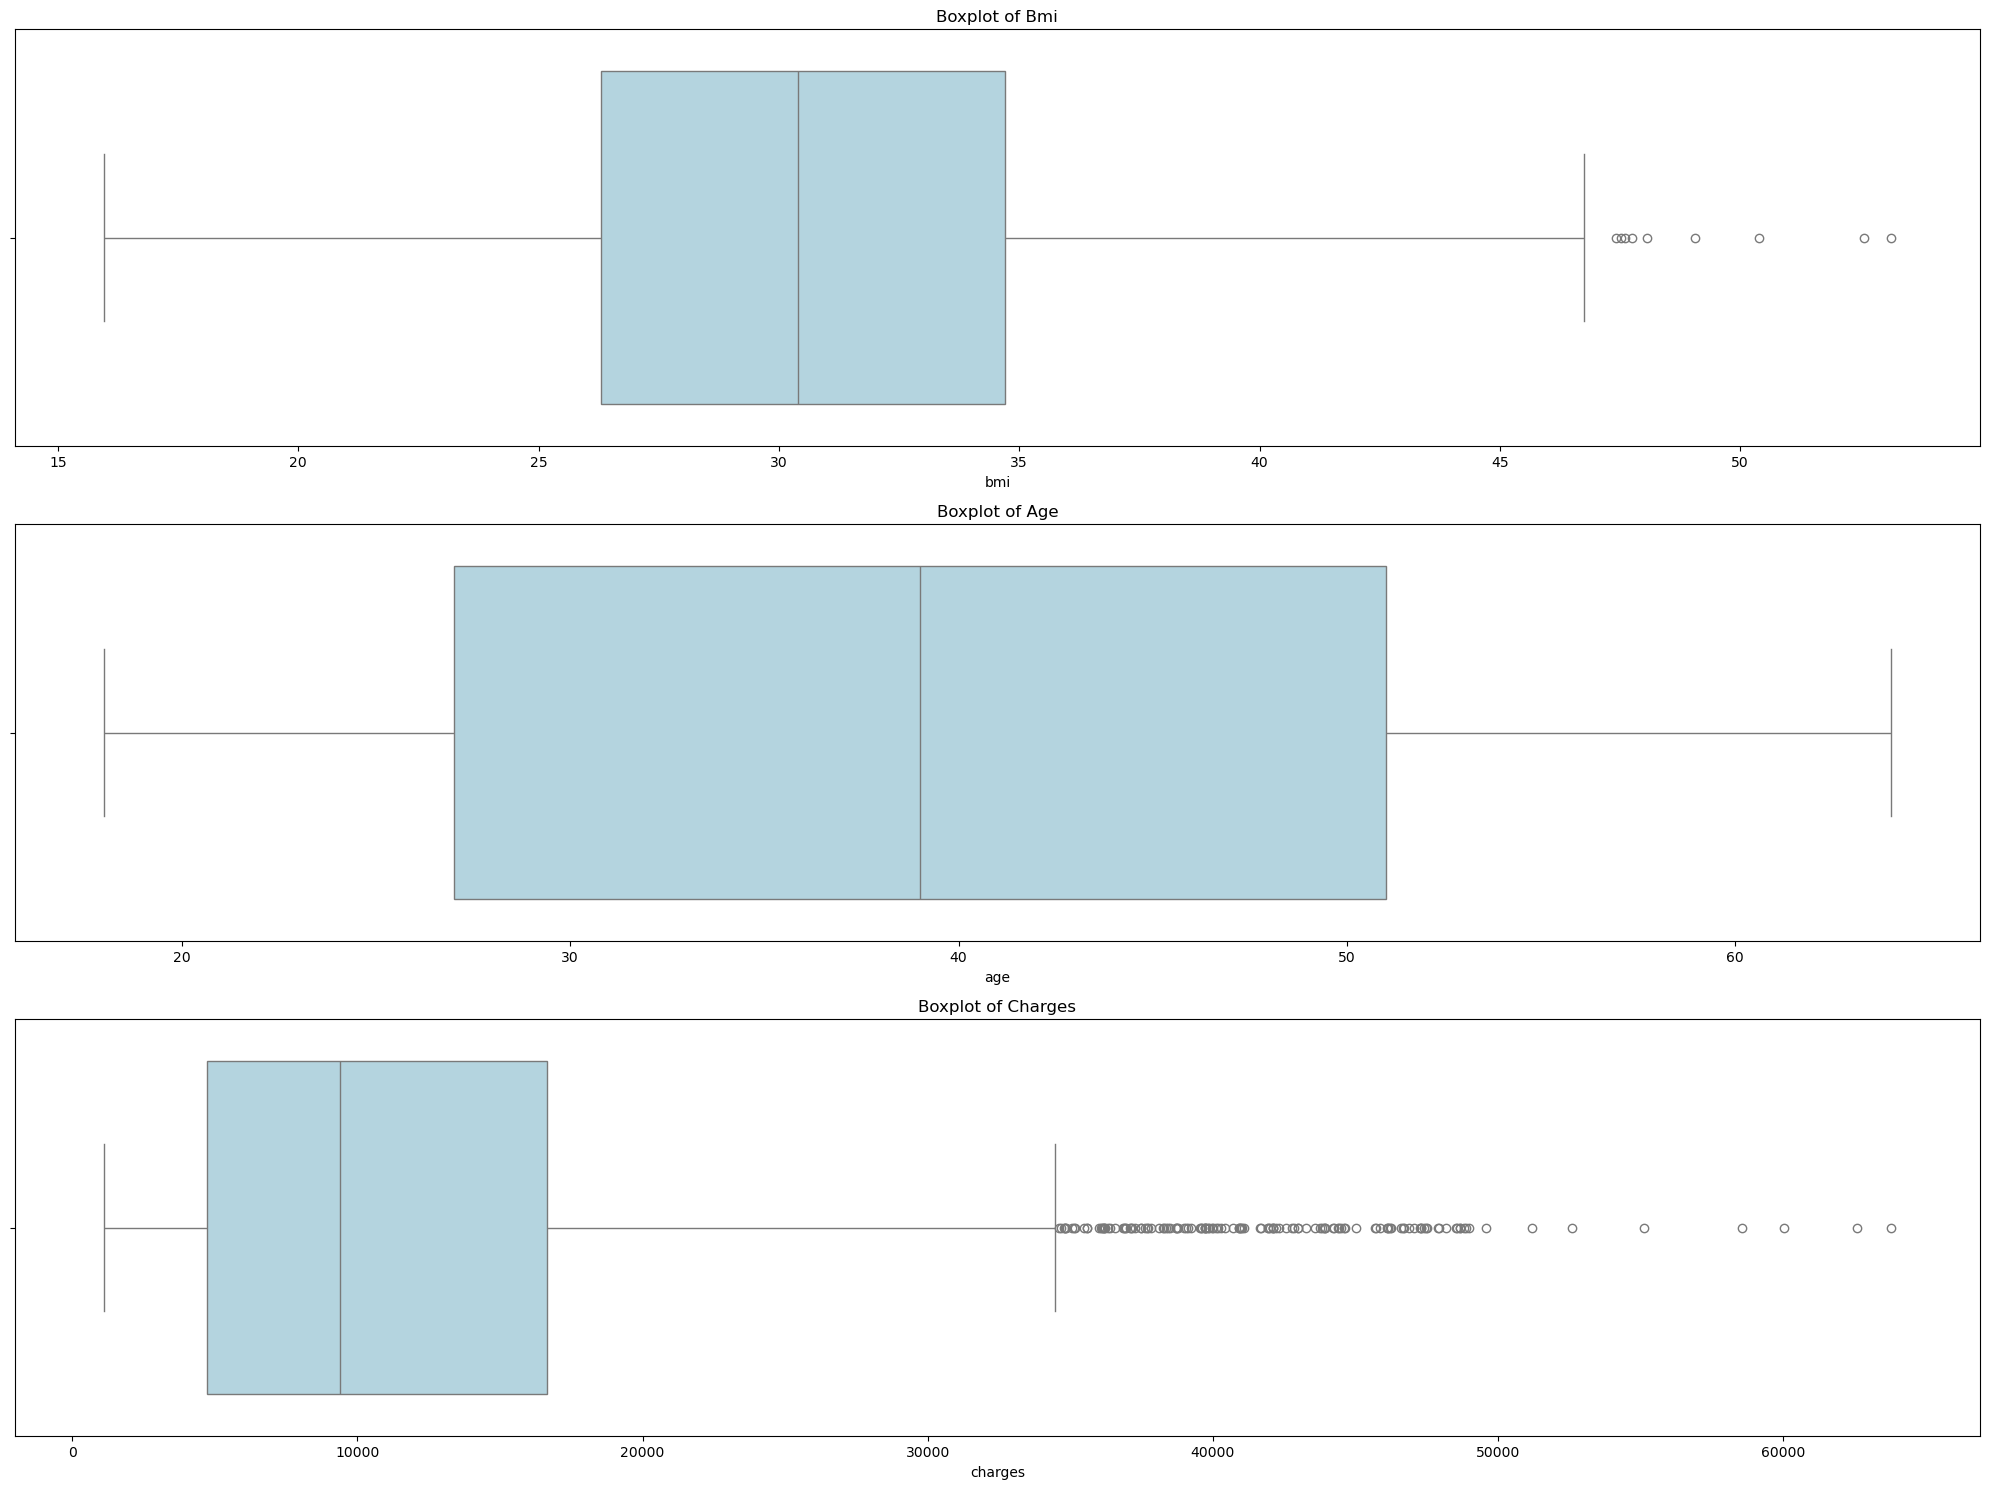

    Column  Number of Outliers
0      bmi                   9
1      age                   0
2  charges                 139


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Columns you want to plot and check outliers for
plot_cols = ['bmi', 'age', 'charges']

# --- Boxplots for Outlier Detection ---
plt.figure(figsize=(20, 15))

for i, col in enumerate(plot_cols, start=1):
    plt.subplot(len(plot_cols), 1, i)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f'Boxplot of {col.capitalize()}')

plt.tight_layout()
plt.show()

# --- Calculate IQR and count outliers ---
Q1 = df[plot_cols].quantile(0.25)
Q3 = df[plot_cols].quantile(0.75)
IQR = Q3 - Q1

outliers_count = (
    (df[plot_cols] < (Q1 - 1.5 * IQR)) |
    (df[plot_cols] > (Q3 + 1.5 * IQR))
).sum()

# Print outlier counts in a neat table
outliers_df = outliers_count.reset_index()
outliers_df.columns = ["Column", "Number of Outliers"]
print(outliers_df)


In [34]:
# --- Categorical Variables ---
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

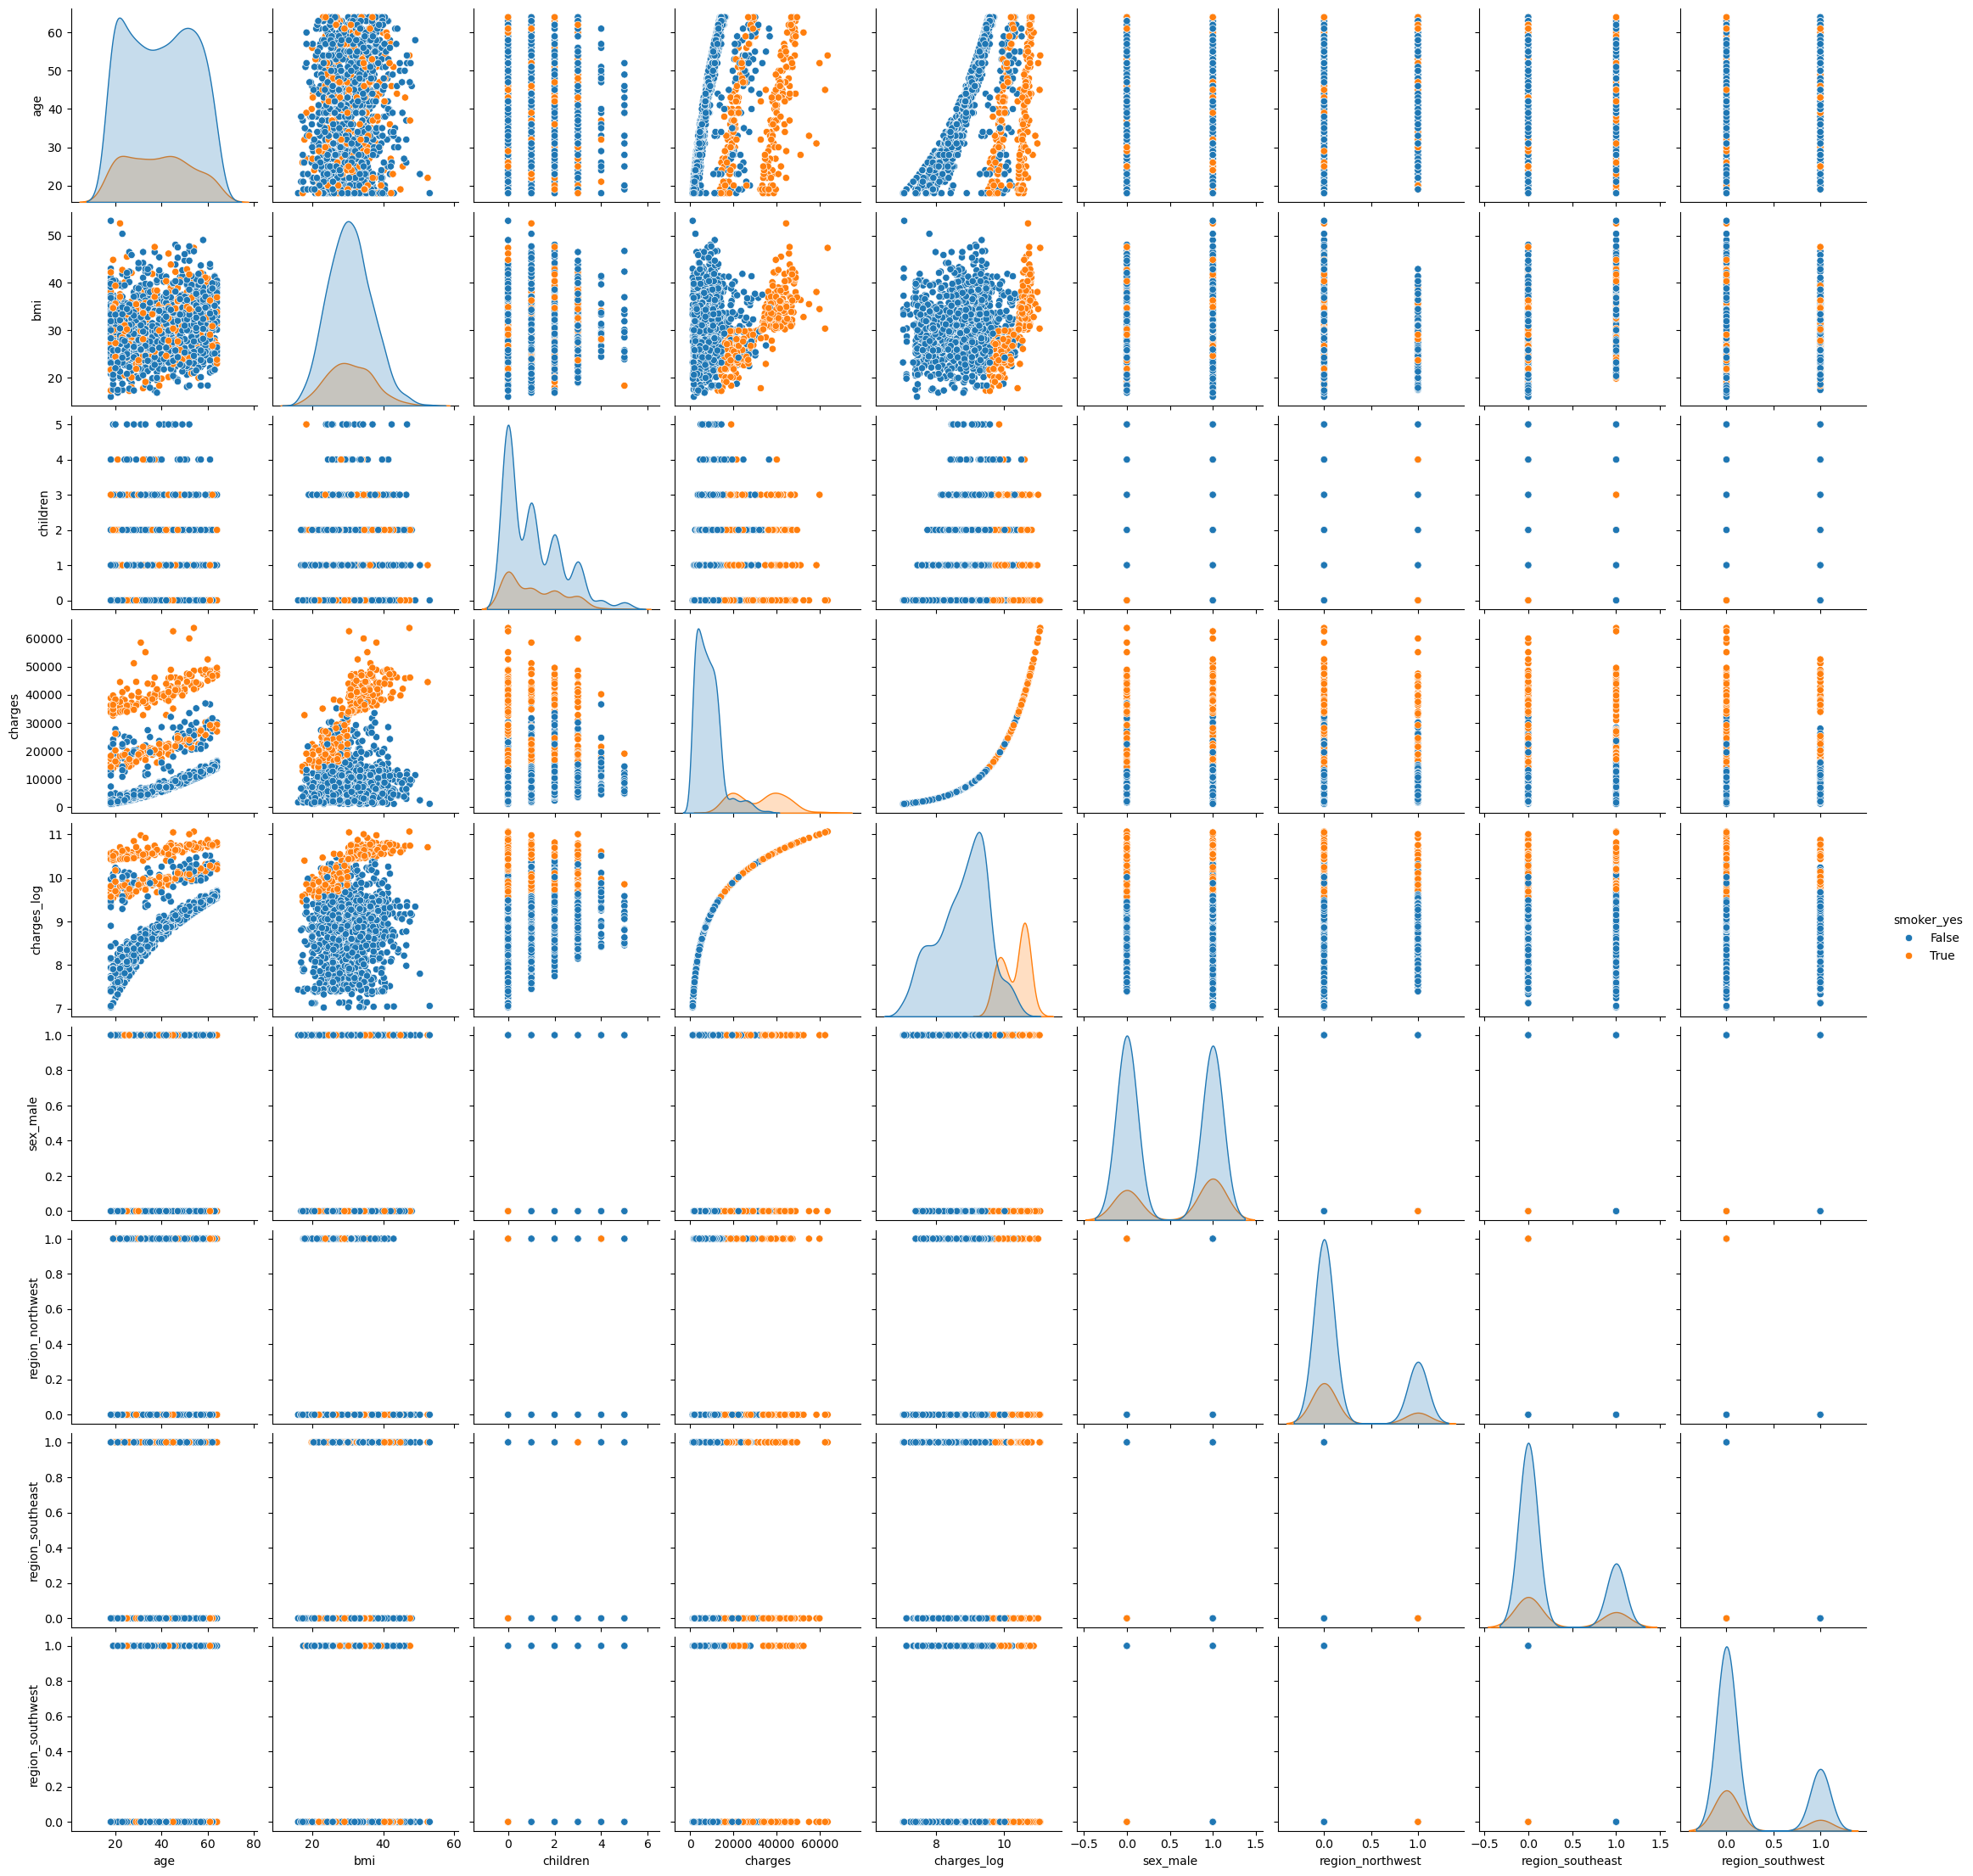

In [37]:
# Pairplot with hue for smoker
sns.pairplot(df_encoded, hue='smoker_yes')
plt.show()

In [39]:
# --- Multicollinearity Check ---
X_vif = df_encoded.drop(columns=['charges', 'charges_log'])
X_vif = X_vif.astype(float)  # Ensure all data is numeric

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

            feature        VIF
0               age   7.686965
1               bmi  11.358443
2          children   1.809930
3          sex_male   2.003185
4        smoker_yes   1.261233
5  region_northwest   1.890281
6  region_southeast   2.265564
7  region_southwest   1.960745


In [41]:
# --- Data Scaling ---
X = X_vif
y = df['charges_log']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [45]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}, R²: {r2_lr:.2f}")

Linear Regression - RMSE: 0.42, MAE: 0.27, R²: 0.80


C:\Users\OUM\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [47]:
# --- Random Forest with Hyperparameter Tuning ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - RMSE: 0.37, MAE: 0.20, R²: 0.85


C:\Users\OUM\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\OUM\AppData\Local\Temp\ipykernel_7916\4287828894.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette="viridis")


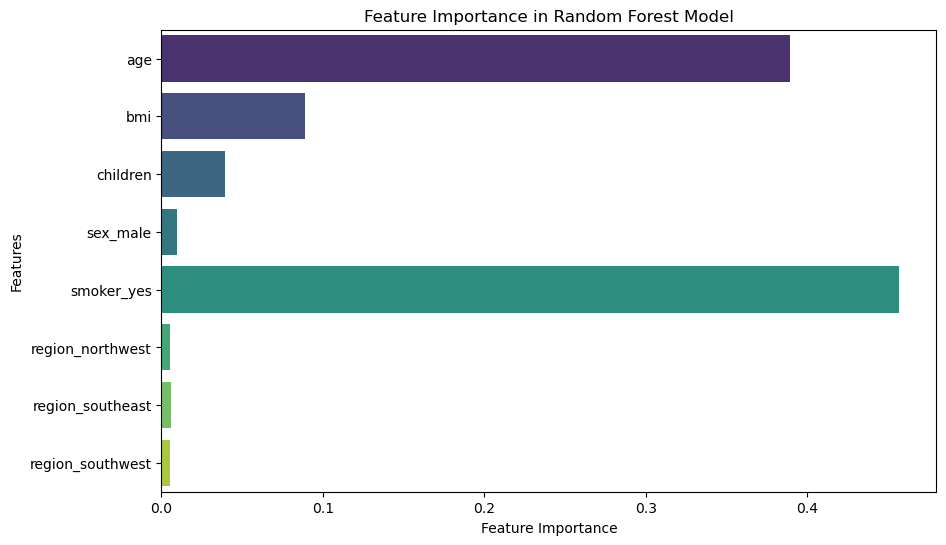

In [55]:
# --- Feature Importance ---
feature_importances = best_rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

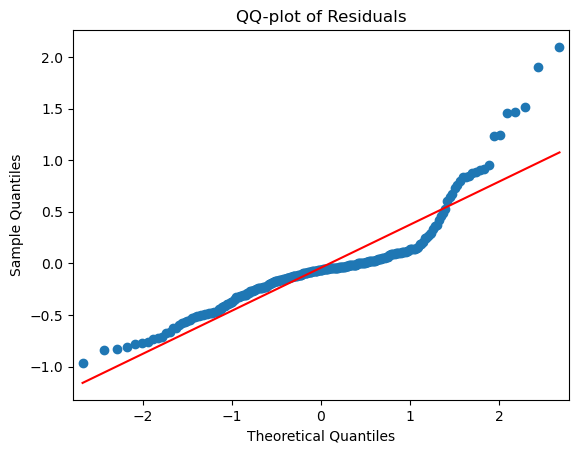

In [57]:
import statsmodels.api as sm

# Residual Analysis
residuals = y_test - y_pred_lr
sm.qqplot(residuals, line='s')
plt.title("QQ-plot of Residuals")
plt.show()

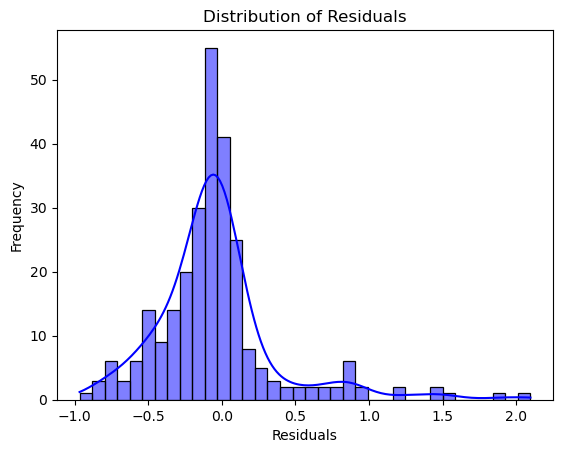

In [59]:
sns.histplot(residuals, kde=True, color='blue')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [61]:
# Cross-Validation
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_rf = np.sqrt(-cv_scores_rf)
print(f"Random Forest Cross-Validation RMSE: {cv_rmse_rf.mean():.2f} ± {cv_rmse_rf.std():.2f}")

NameError: name 'rf_model' is not defined